In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import cv2
import json
from PIL import Image 

In [52]:
# Загружаем подготовленные данные 
x_train = np.load('data/x_train.npy')
y_train = np.load('./data/y_train.npy')
x_test = np.load('./data/x_val.npy')
y_test = np.load('./data/y_val.npy')

In [2]:
# Строим модель

def build_model():
    x = tf.keras.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(out)
    out =  tf.keras.layers.MaxPool2D((2,2))(out1)
        
    out = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(out)
    out =  tf.keras.layers.MaxPool2D((2,2))(out2)
    
        
    out = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)
    out =  tf.keras.layers.MaxPool2D((2,2))(out3)
    
        
    out = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    out =  tf.keras.layers.MaxPool2D((2,2))(out4)
    
    out = tf.keras.layers.Conv2D(1024, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3,3), padding='same', activation='relu')(out)
    
    out = tf.keras.layers.Conv2DTranspose(512, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)
    
    out = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    
    out = tf.keras.layers.Conv2DTranspose(256, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)
    
    out = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)
    
    out = tf.keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)
    
    out = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(out)
    
    out = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)
    
    out = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(out)
    # Выбираем softmax, так как формально класса 2 - пины и фон 
    out = tf.keras.layers.Conv2D(2, (3,3), padding='same', activation='softmax')(out)
    
    return  tf.keras.Model(inputs = x, outputs = out)
    
model = build_model()

In [3]:
# воссоздаем модель 

model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('./data/U-net/weights.hdf5')

In [341]:
def pins2json_(img: np.array, mod: str):
    """Функция генерации json-файла пинов.
    
    На выходе создается json-файл вида:
    { 1 pin : [leftTop , rightBotoom],
    ...
    
    ...
      N pin : [leftTop , rightBotoom]
    }
    где * pin - номер пина,
    leftTop - координаты левого верхнего угла квардрата соответствующего пина
    rightBottom - координаты правого нижнего угла квардрата соответствующего пина.
    
    В зависимости от параметра mod, определеятся очередность нумерции пинов
    mod = {'rt', 'rb', 'lt', 'lb'}
    
    пин № 1 (0) будет будет присвоен в зависимости от параметра mod: 
    
    rt -  правому верхнему 
    rb - правому нижнему 
    lt - левому верхнему 
    lb - левому нижнему    
    """
    
    def dumping_json(cen_sorted: np.array):
        """Функция создания 'квадратов' для обозначения пинов на фото 
        и последущая упаковка координат углов в json-файл"""
        
        l_mean = (cen_sorted[cen_sorted[:, 0] < 125][:,0]).mean()
        r_mean = (cen_sorted[cen_sorted[:, 0] > 125][:,0]).mean()
        cen_sorted[:,0] [cen_sorted[:,0] > 125] = int(r_mean)
        cen_sorted[:,0] [cen_sorted[:,0] < 125]= int(l_mean)
        
        # Создаем координаты правого верхнего и левого нижнего пинов путем отступа 5 px.
        # В итоге получится квадрат со стороной 10 px 
        
        rec = [[[cnt[0] - 5, cnt[1] - 5],
                [cnt[0] + 5, cnt[1] + 5]] for cnt in cen_sorted]
         
#       Создаем dict для харнения будущих координат 'квадратов' 
        json_dict = {}
#       Начинаем цикл по координатам
        for num, item in enumerate(rec):
            json_dict[num] = list(item)
#       Дампим json 
        with open('pins.json', 'w') as f:
            json.dump(json_dict, f)
            
#   Сохраняем исходные размерности изображения
    width, height = img.shape[:2]

#   Так как нейронная сеть работает с изображениями 256х256, изменяем размерность изображения 
    img = cv2.resize(img, (256, 256))
    
#   Определяем коэффициенты для корректировки итоговых координат пинов
    kx, ky = width / 256, height / 256 
    
    
#   Сегмнтируем изобраэжение
    det = model.predict(img[None, ...])[0,...][:,:,1]
    
#   Устанавливаем пороги при которых будем считать что пиксель является пином, а не вотно 
    det = np.where(det > 0.018, 255, 0)
    
#   Находим контуры выделенных пинов
    contours, _ = cv2.findContours(
        det.copy(),
        cv2.RETR_FLOODFILL ,cv2.CHAIN_APPROX_SIMPLE)
    
#   Формируем центры найденных областей, центром будем считать мат. ожидание кординат контура
    centers = list()
    for cnt in contours[0:-1:2]:
        if cv2.contourArea(cnt) > 200 and( cnt.mean(axis=0)[0][0] > 175 or cnt.mean(axis=0)[0][0] < 75):
            centers.append(cnt.mean(axis=0))
            
#   Масштабируем координаты
    centers = np.array(centers).reshape(-1,2)
    centers[:, 0] = (centers[:, 0] * ky).astype('int32')
    centers[:, 1] = (centers[:, 1] * kx).astype('int32')
    
    
#   Мод = 'rt'
    if mod == "rt":
        cen_sorted = sorted(
            centers[centers[:, 0] > 128], key = lambda x : x[1]
      ) + sorted(
            centers[centers[:, 0] < 128], key = lambda x : x[1], reverse=True
      )
        
        dumping_json(cen_sorted = np.array(cen_sorted))
                           
#   Мод = 'rb'
    if mod == "rb": 
        cen_sorted = sorted(
            centers[centers[:, 0] > 128], key = lambda x : x[1], reverse = True
      ) + sorted(
            centers[centers[:, 0] < 128], key = lambda x : x[1],
      )
        
        dumping_json(cen_sorted = np.array(cen_sorted))

        
#   Мод = 'lt'
    if mod == "lt": 
        cen_sorted = sorted(
            centers[centers[:, 0] < 128], key = lambda x : x[1], reverse = True
      ) + sorted(
            centers[centers[:, 0] > 128], key = lambda x : x[1],
      )
        
        dumping_json(cen_sorted = np.array(cen_sorted))
        
                           
#   Мод = 'lb'
    if mod == "lb": 
        cen_sorted = sorted(
            centers[centers[:, 0] < 128], key = lambda x : x[1], 
      ) + sorted(
            centers[centers[:, 0] > 128], key = lambda x : x[1], reverse = True
      )
        
        dumping_json(cen_sorted = np.array(cen_sorted)   ) 
        return centers



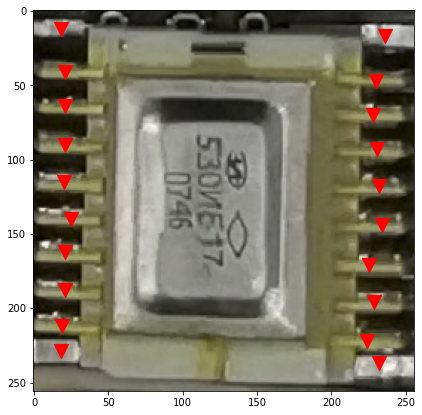

In [246]:
i=0
plt.figure(figsize=(7,7))
cen = np.array(pins2json(x_train[i], 'lb'))
plt.imshow(x_train[i])
plt.scatter(cen[:,0], cen[:,1], marker = 'v', s=200, color= 'r')
# plt.scatter(cen[0,0], cen[0,1], marker = '*', s=200, color= 'g')
plt.show()

In [4]:
def pins2json(img_path: str, mod: np.array):
    """Функция генерации json-файла пинов.
    
    На выходе создается json-файл вида:
    { 1 pin : [leftTop , rightBotoom],
    ...
    
    ...
      N pin : [leftTop , rightBotoom]
    }
    где * pin - номер пина,
    leftTop - координаты левого верхнего угла квардрата соответствующего пина
    rightBottom - координаты правого нижнего угла квардрата соответствующего пина.
    
    В зависимости от параметра mod, определеятся очередность нумерции пинов
    mod = {'rt', 'rb', 'lt', 'lb'}
    
    пин № 1 (0) будет будет присвоен в зависимости от параметра mod: 
    
    rt -  правому верхнему 
    rb - правому нижнему 
    lt - левому верхнему 
    lb - левому нижнему    
    """
    
    def dumping_json(cen_sorted: np.array):
        """Функция создания 'квадратов' для обозначения пинов на фото 
        и последущая упаковка координат углов в json-файл"""
        
        # Получаем центральную координату y для микросхемы для выравнивания меток пинов по вертикали
        mean_val = abs(y1 - y2) /2 + min(y1,y2)
        
        # Получаем средние значения для координат y для левой (l_mean) части и правой (r_mean) микросхемы
        l_mean = (cen_sorted[cen_sorted[:, 0] < mean_val][:,0]).mean()
        r_mean = (cen_sorted[cen_sorted[:, 0] > mean_val][:,0]).mean()
        
        # Заменяем все значения координат y на соответствующие для "выравнивания" 
        cen_sorted[:,0] [cen_sorted[:,0] > mean_val] = int(r_mean)
        cen_sorted[:,0] [cen_sorted[:,0] < mean_val]= int(l_mean)
        
        # Создаем координаты правого верхнего и левого нижнего пинов путем отступа 5 px.
        # В итоге получится квадрат со стороной 10 px 
        
        rec = [[[cnt[0] - 5, cnt[1] - 5],
                [cnt[0] + 5, cnt[1] + 5]] for cnt in cen_sorted]
         
#       Создаем dict для харнения будущих координат 'квадратов' 
        json_dict = {}
#       Начинаем цикл по координатам
        for num, item in enumerate(rec):
            json_dict[num] = list(item)
#       Дампим json 
        with open('pins.json', 'w') as f:
            json.dump(json_dict, f)
            
    main_img = Image.open(img_path)
    main_img = tf.image.resize(main_img, (3200, 4800))
    main_img = np.array(main_img)/255
    
    x1, y1, x2, y2 = mod
    
    img = main_img[min(x1,x2):max(x1,x2), min(y1,y2):max(y1,y2)]

    if x1 > x2 and y1 > y2 : mod = 'lb' # lb
    if x1 < x2 and y1 > y2 : mod = 'rt' # rt
    if x1 < x2 and y1 < y2 : mod = 'lt' # lt
    if x1 > x2 and y1 < y2 : mod = 'rb' # rb
    
            
#   Сохраняем исходные размерности изображения
    width, height = img.shape[:2]

#   Так как нейронная сеть работает с изображениями 256х256, изменяем размерность изображения 
    img = cv2.resize(img, (256, 256))
    
#   Определяем коэффициенты для корректировки итоговых координат пинов
    kx, ky = width / 256, height / 256 
    
    
#   Сегмнтируем изобраэжение
    det = model.predict(img[None, ...])[0,...][:,:,1]
    
#   Устанавливаем пороги при которых будем считать что пиксель является пином, а не вотно 
    det = np.where(det > 0.018, 255, 0)
    
#   Находим контуры выделенных пинов
    contours, _ = cv2.findContours(
        det.copy(),
        cv2.RETR_FLOODFILL ,cv2.CHAIN_APPROX_SIMPLE)
    
#   Формируем центры найденных областей, центром будем считать мат. ожидание кординат контура
    centers = list()
    for cnt in contours[0:-1:2]:
        if cv2.contourArea(cnt) > 200 and( cnt.mean(axis=0)[0][0] > 175 or cnt.mean(axis=0)[0][0] < 75):
            centers.append(cnt.mean(axis=0))
            
#   Масштабируем координаты
    centers = np.array(centers).reshape(-1,2)
    centers[:, 0] = (centers[:, 0] * ky).astype('int32') + min(y1,y2)
    centers[:, 1] = (centers[:, 1] * kx).astype('int32') + min(x1,x2)
    
#   Мод = 'rt'
    if mod == "rt":
        cen_sorted = sorted(
            centers[centers[:, 0] > 128], key = lambda x : x[1]
      ) + sorted(
            centers[centers[:, 0] < 128], key = lambda x : x[1], reverse=True
      )
        
        dumping_json(cen_sorted = np.array(cen_sorted))
        return centers
                           
#   Мод = 'rb'
    if mod == "rb": 
        cen_sorted = sorted(
            centers[centers[:, 0] > 128], key = lambda x : x[1], reverse = True
      ) + sorted(
            centers[centers[:, 0] < 128], key = lambda x : x[1],
      )
        
        dumping_json(cen_sorted = np.array(cen_sorted))
        return centers

        
#   Мод = 'lt'
    if mod == "lt": 
        cen_sorted = sorted(
            centers[centers[:, 0] < 128], key = lambda x : x[1], reverse = True
      ) + sorted(
            centers[centers[:, 0] > 128], key = lambda x : x[1],
      )
        
        dumping_json(cen_sorted = np.array(cen_sorted))
        return centers
        
                           
#   Мод = 'lb'
    if mod == "lb": 
        cen_sorted = sorted(
            centers[centers[:, 0] < 128], key = lambda x : x[1], 
      ) + sorted(
            centers[centers[:, 0] > 128], key = lambda x : x[1], reverse = True
      )
        
        dumping_json(cen_sorted = np.array(cen_sorted)   ) 
        return centers



In [7]:
bboxes = [[1226,1724,182,271],
[2740,1452,183,294],
[1231,965,183,266],
[213,1459,181,279],
[2250,1705,172,284],
[1743,1218,184,267],
[724, 1708, 173, 281],
[3741, 1461, 208, 306],
[1235, 1477, 174, 268],
[224, 1715, 173, 292],
[1746, 1727, 199, 275],
[2252, 1463, 182, 322],
[1237, 1222, 178, 264],
[3253, 1727, 182, 269],
[3769, 1736, 189, 269],
[3255, 1452, 175, 305],
[722, 1185, 184, 294],
[2756, 1727, 191, 253],
[1740, 1437, 169, 287],
[719, 1458, 178, 270],
[217, 1217, 181, 269],
[1720, 961, 192, 288]]


In [9]:
test_img = Image.open('IMG_000126.JPG')
test_img = tf.image.resize(test_img, (3200, 4800))
fig, ax  = plt.subplots(figsize=(30,20))
plt.imshow(test_img/255)

centers = []

for box in bboxes[0:1]:
    img = (np.array(test_img)/255)[box[1]:box[1]+box[3], box[0]-75:box[0]+box[2]+75]
    
    cen = pins2json_(img, 'lb')
    cen[:,0], cen[:,1] = cen[:,0] + box[0]-75, cen[:,1] + box[1]
    plt.scatter(cen[:,0], cen[:,1], marker = 'v', s=100)
    

Wall time: 35.2 s


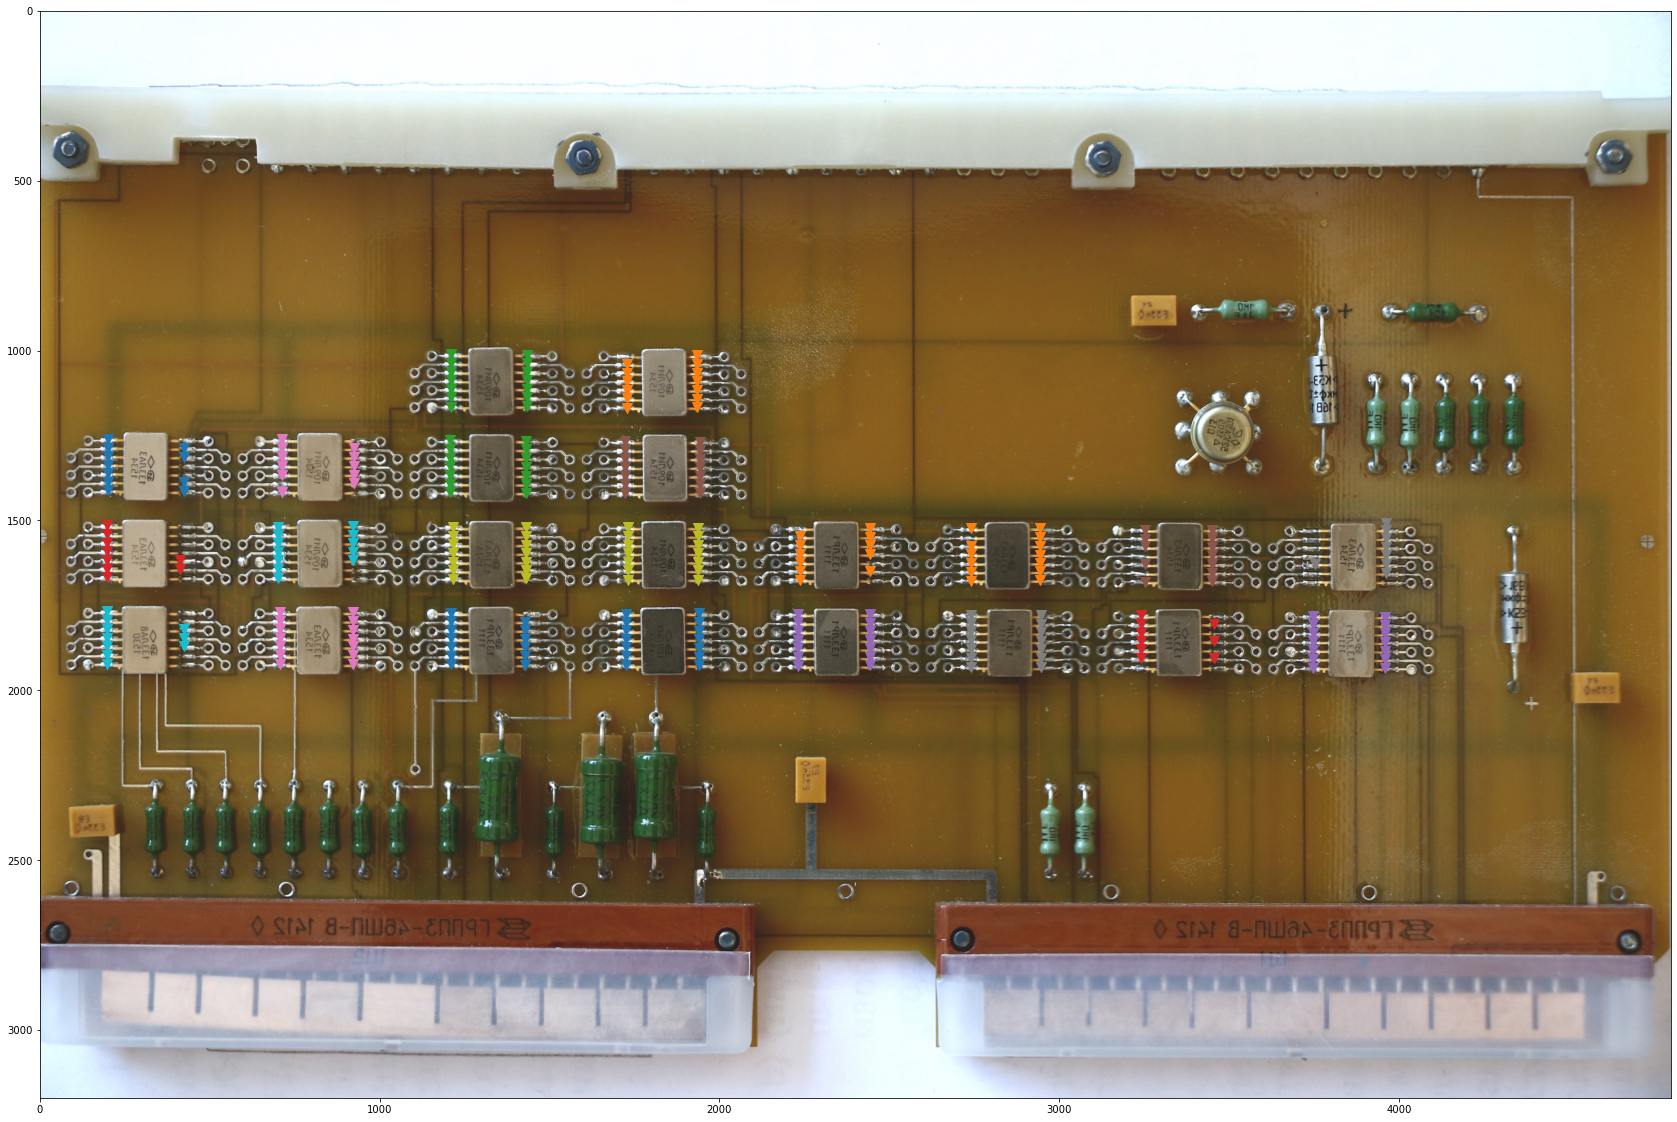

In [10]:
%%time
test_img = Image.open('IMG_000126.JPG')
test_img = tf.image.resize(test_img, (3200, 4800))
fig, ax  = plt.subplots(figsize=(30,20))
plt.imshow(test_img/255)

for box in bboxes:
    box = [box[1]+box[3],  box[0]-75, box[1], box[0] +  box[2] + 75]
    pins2json('IMG_000126.JPG', box)
    with open('pins.json') as f:
        d = json.load(f)
    tt = np.array([i[0] for i in  list(d.values())])
    plt.scatter(tt[:,0], tt[:,1], marker = 'v', s=100)
    

## 1. Имеется фотография ячейки

## 2. Последовательно "вырезаем" каждую микросхему и формируем json-файл с координатами "меток" пинов

## 3. В результате